In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from PIL import Image

In [2]:
# Load and preprocess data
def load_spectrograms(data_dir, img_size=(128, 128)):
    X, y = [], []
    labels = os.listdir(data_dir)
    for label in labels:
        files = os.listdir(os.path.join(data_dir, label))
        for file in files:
            file_path = os.path.join(data_dir, label, file)
            # Load image
            img = Image.open(file_path).convert('L')  # Convert to grayscale
            img = img.resize(img_size)
            X.append(np.array(img))
            y.append(label)
    return np.array(X), np.array(y)

In [3]:
data_dir = './data/images_original'
X, y = load_spectrograms(data_dir)

In [7]:
# Normalize data
X = X / 255.0
X = X[..., np.newaxis]  # Add channel dimension (e.g., (128, 128, 1))

In [8]:
X.shape

(999, 128, 128, 1)

In [11]:
# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

In [17]:
# Split data
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=42)

In [18]:
len(X_train), len(X_val), len(X_test)

(599, 200, 200)

In [25]:
# Define CNN model
def build_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(10, activation='softmax')  # 10 genres
    ])
    return model

In [26]:
model = build_cnn(X_train.shape[1:])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

In [29]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('cnn_model.keras', save_best_only=True, monitor='val_accuracy')
]

In [30]:
# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


c:\Users\marti.MARTIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.1131 - loss: 2.5090 - val_accuracy: 0.0850 - val_loss: 2.3017
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.1211 - loss: 2.2989 - val_accuracy: 0.1600 - val_loss: 2.2838
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.1609 - loss: 2.2564 - val_accuracy: 0.2150 - val_loss: 2.1421
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.1711 - loss: 2.1978 - val_accuracy: 0.2000 - val_loss: 2.1023
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.2454 - loss: 2.0965 - val_accuracy: 0.2200 - val_loss: 2.0940
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.1986 - loss: 2.1287 - val_accuracy: 0.2050 - val_loss: 2.1304
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.2513 - loss: 2.0727 - val_accuracy: 0.2750 - val_loss: 1.9457
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.2605 - loss: 2.0351 - val_accuracy: 0.3600 - val_lo

In [31]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4943 - loss: 1.4309
Test Accuracy: 0.4800


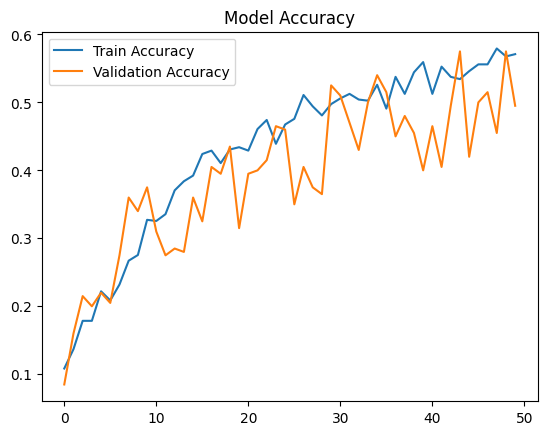

In [32]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()